In [1]:
import os
import pandas as pd
from datetime import datetime
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

from src.utils.general import get_db_conn

In [2]:
creds_folder = '../conf/local/'
fpath = os.path.join(creds_folder, 'credentials.yaml')
db_con = get_db_conn(fpath)

In [3]:
project_folder = '/mnt/data/experiment_data/aclu/issue_classify_tests/first_complete_test'

#### Experiment hashes

In [4]:
q = """
        select * from issue_classifier_metadata.experiment_runs where run_status='completed'
    """
df = pd.read_sql(q, db_con)

In [5]:
exp_hashes = df['experiment_hash'].tolist()

#### Models in the experiment

In [132]:
# exp_hsh = exp_hashes[1]
exp_hsh = '1736a4534070b0a6550e30845130d39c'
q = """
        select 
            model_id,
            model_group_id,
            model_hash,
            train_matrix_uuid,
            issue_area,
            model_type,
            hyperparameters 
        from issue_classifier_metadata.models join issue_classifier_metadata.model_groups using(model_group_id) 
        where built_by_experiment='{}' and model_type like '%Random%'
    """.format(exp_hsh)
exp_hsh

'1736a4534070b0a6550e30845130d39c'

In [133]:
models_in_exp = pd.read_sql(q, db_con)

In [134]:
mod_groups = models_in_exp['model_group_id'].unique()
mod_groups

array([585, 588, 591, 595, 599, 602, 605, 608, 611, 614, 617, 620, 623,
       626, 628, 630, 634, 636, 639, 643, 648, 651, 654, 658, 664, 666,
       668, 671, 674, 677, 679, 680, 683, 685])

In [135]:
mod_group_to_analyse = 685
models_in_exp.groupby('model_group_id').first()['hyperparameters'].loc[mod_group_to_analyse]

{'n_jobs': -1,
 'criterion': 'entropy',
 'max_depth': 100,
 'class_weight': None,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'min_samples_split': 25}

In [136]:
issue_area = models_in_exp['issue_area'].unique()
issue_area = issue_area[0]
issue_area

'immigrant_rights'

#### Insepcting only a model group

In [137]:
msk = models_in_exp['model_group_id'] == mod_group_to_analyse
models = models_in_exp[msk]['model_id'].tolist()

#### Joining the matrices and the models

Only fetching the test matrices for now

In [138]:
q = """
        with test_mats as(
            select 
                model_id, 
                max(matrix_uuid) as matrix_uuid 
            from issue_classifier_results.test_predictions where experiment_hash='{0}' and model_id in {1}
            group by model_id
        )
        select 
            model_id,
            matrix_id,
            matrix_uuid as test_uuid,
            matrix_type,
            feature_start_time,
            time_split_index,
            built_by_experiment
        from test_mats join issue_classifier_metadata.matrices using(matrix_uuid)
    """.format(exp_hsh, tuple(models))

In [142]:
matrices_models = pd.read_sql(q, db_con)
matrices_models

,model_id,matrix_id,test_uuid,matrix_type,feature_start_time,time_split_index,built_by_experiment
0,5228,2009-07-01 00:00:00_2009-12-30 00:00:00,46a397fec4964457aaec8d231f6f42cf,test,2009-07-01,0,1736a4534070b0a6550e30845130d39c
1,5230,2010-07-01 00:00:00_2010-12-30 00:00:00,e23bd001f6f246358e8b4e0433591d06,test,2010-07-01,1,1736a4534070b0a6550e30845130d39c
2,5231,2011-07-01 00:00:00_2011-12-30 00:00:00,a23a8810afac4d5388f739074ce24b98,test,2011-07-01,2,1736a4534070b0a6550e30845130d39c
3,5232,2012-07-01 00:00:00_2012-12-30 00:00:00,287b9ac566554816af49d11447b4bf24,test,2012-07-01,3,1736a4534070b0a6550e30845130d39c
4,5234,2013-07-01 00:00:00_2013-12-30 00:00:00,218a0163cb124c5d88754d51e98f6a92,test,2013-07-01,4,1736a4534070b0a6550e30845130d39c
5,5236,2014-07-01 00:00:00_2014-12-30 00:00:00,84ea896cd64f4d00bb0bee10e98a6f60,test,2014-07-01,5,1736a4534070b0a6550e30845130d39c


#### Fetch predictions for a model/matrix

Selecting a time split index

In [165]:
time_idx = 4

In [166]:
msk = matrices_models['time_split_index'] == time_idx
model_id = matrices_models[msk]['model_id'].iloc[0]
matrix_uuid = matrices_models[msk]['test_uuid'].iloc[0]

In [167]:
q = """
        select 
            entity_id,
            as_of_date,
            model_id,
            issue_area,
            score,
            label_value
        from issue_classifier_results.test_predictions 
        where model_id={} and matrix_uuid='{}'
""".format(model_id, matrix_uuid)

In [168]:
model_test_results = pd.read_sql(q, db_con)

#### Score distribution

Total: 17809, in issue area: 38, prevalance 0.002133752597001516


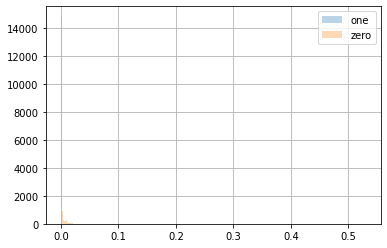

In [169]:
msk = model_test_results['label_value'] == 1
model_test_results[msk]['score'].hist(bins=100, alpha=0.3, label='one')
model_test_results[~msk]['score'].hist(bins=100,  alpha=0.3, label='zero')
plt.legend()

num_immigrant_rights_bills = model_test_results[msk].shape[0]
num_total_bills = model_test_results.shape[0]
prevalance = num_immigrant_rights_bills/num_total_bills
print('Total: {}, in issue area: {}, prevalance {}'.format(num_total_bills, num_immigrant_rights_bills, prevalance))

### Roc curve

In [148]:
from sklearn.metrics import roc_curve

In [149]:
fpr, tpr, thresholds = roc_curve(model_test_results['label_value'], model_test_results['score'])

Text(0, 0.5, 'TPR')

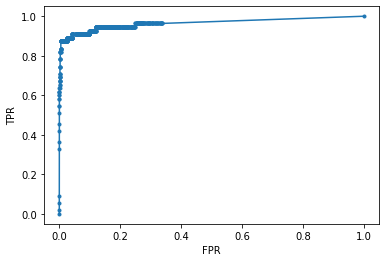

In [150]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [151]:
confusion_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns=['fpr', 'tpr', 'thresholds'])

In [152]:
msk = confusion_df['fpr']>=0.8

In [153]:
confusion_df[msk]

,fpr,tpr,thresholds
839,1.0,1.0,0.0


#### PR-curve Sklearn

In [154]:
from sklearn.metrics import precision_recall_curve

In [155]:
precision, recall, thresholds_2 = precision_recall_curve(model_test_results['label_value'], model_test_results['score'], pos_label=1)

thresholds_2 = np.append(thresholds_2, 1)

def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    df = df_1.merge(df_2, on="threshold")
    return df

In [156]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
msk = metrics_report['recall'] >=0.8

In [157]:
metrics_report[msk].sort_values('recall')

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
798,0.03491,0.454545,0.818182,0.584416,0.818182,0.003253,0.996747,0.181818
793,0.03172,0.391304,0.818182,0.529412,0.818182,0.004217,0.995783,0.181818
794,0.03226,0.398230,0.818182,0.535714,0.818182,0.004096,0.995904,0.181818
797,0.03476,0.445545,0.818182,0.576923,0.818182,0.003373,0.996627,0.181818
796,0.03460,0.436893,0.818182,0.569620,0.818182,0.003494,0.996506,0.181818
...,...,...,...,...,...,...,...,...
50,0.00079,0.011752,0.963636,0.023220,0.963636,0.268478,0.731522,0.036364
51,0.00080,0.011770,0.963636,0.023256,0.963636,0.268056,0.731944,0.036364
52,0.00081,0.011817,0.963636,0.023348,0.963636,0.266972,0.733028,0.036364
36,0.00063,0.011120,0.963636,0.021987,0.963636,0.283899,0.716101,0.036364


In [158]:
# fig, ax = plt.subplots()
# fig.set_size_inches(12, 6)
# sns.lineplot(data=metrics_report, x='threshold', y='precision', ax=ax, color='royalblue', alpha=1 , label='precision')
# sns.lineplot(data=metrics_report, x='threshold', y='recall', ax=ax, color='orange', alpha=1, label='recall')
# plt.title('Precision & Recall change when we go down the scores')
# ax.set_ylabel('Value')
# ax.set_xlabel('The score threshold')
# plt.axhline(y=0.8)

##### Evaluations

In [159]:
import numpy as np
from src.utils.modeling import get_top_k, get_precision_at_k, get_recall_at_k

In [160]:
temp_df = pd.DataFrame()
for k in np.arange(0.01, 1.01, 0.01):
    d = dict()
    top_k = get_top_k(model_test_results, k=k)
    d['k'] = np.round(k,2)
    d['precision'] = get_precision_at_k(top_k)
    d['recall'] = get_recall_at_k(top_k, model_test_results)
    temp_df = temp_df.append(d, ignore_index=True)
    

In [161]:
msk = temp_df['recall']>=0.8

In [163]:
# temp_df[msk]

#### Note

The precision for fixed recall at 80% is 0.383342 (From the PR-curve data from sklearn)

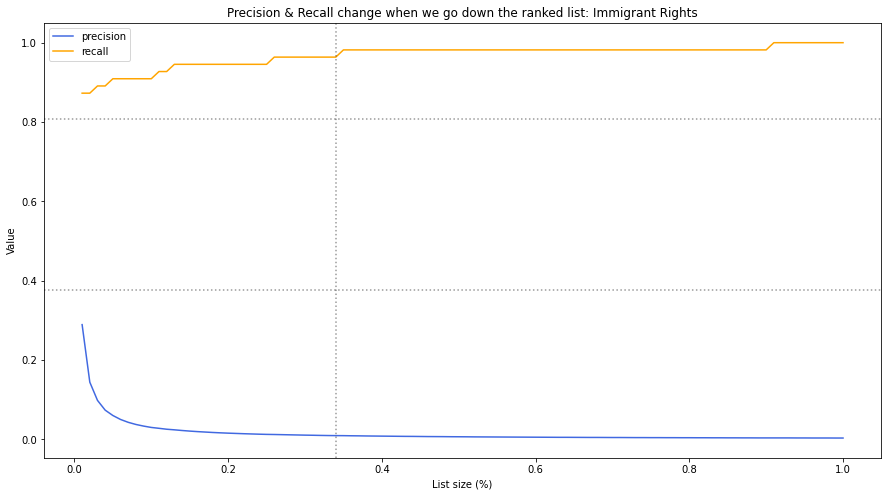

In [164]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.lineplot(data=temp_df, x='k', y='precision', ax=ax, color='royalblue', alpha=1, label='precision')
sns.lineplot(data=temp_df, x='k', y='recall', ax=ax, color='orange', alpha=1, label='recall')
plt.title('Precision & Recall change when we go down the ranked list: Immigrant Rights')
ax.set_ylabel('Value')
ax.set_xlabel('List size (%)')
plt.axhline(y=0.8071, linestyle='dotted', alpha=0.4, color='k')
plt.axhline(y=0.3757, linestyle='dotted', alpha=0.4,  color='k')
plt.axvline(x=0.34, linestyle='dotted', alpha=0.4,  color='k')
plt.legend()
# plt.arrow(0.34, 0.3757, 0.1, 0.1)
# plt.arrow(0.34, 0.807121, 0.1, 0.1)

In [30]:
# sns.scatterplot(data=model_test_results, x='score', y='label_value')

### Load model

In [25]:
msk = models_in_exp['model_id'] == model_id
mod_hash = models_in_exp[msk]['model_hash'].iloc[0]
mod_hash

'70cbc46e1b2236d9ac55a4efd6e9a2be'

In [26]:
mod_obj = joblib.load(os.path.join(project_folder, 'models',mod_hash))

In [27]:
feature_importance = mod_obj.feature_importances_

### Load matrix

In [28]:
test_mat_data = pd.read_csv(os.path.join(project_folder, 'matrices', matrix_uuid+'.csv'))

In [29]:
test_mat_data = test_mat_data.set_index(['entity_id', 'as_of_date'])

In [30]:
label_columns = [x for x in test_mat_data.columns if '_label' in x]

In [31]:
vocabulary = [x for x in test_mat_data.columns if '_label' not in x]

#### Feature importances

In [32]:
importances = pd.DataFrame()
for i, word in enumerate(vocabulary):
    d = dict()
    d['word'] = word
    d['importance'] = feature_importance[i]
    
    importances =importances.append(d, ignore_index=True)

In [33]:
top_words = importances.sort_values('importance', ascending=False)[:20]

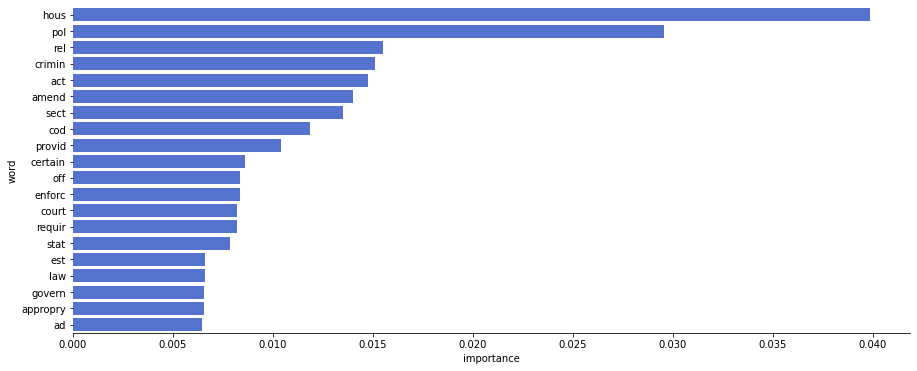

In [35]:
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x="importance", y="word", data=top_words, ax=ax, color='royalblue')
sns.despine(left=True, bottom=False)

### TODO:

1. Precision graph
2. Important keywords
3. Analyse a different issue area

### Plots

1. For each issue area Time vs precision for each model group